2 2
Number of features matched in frames 0 and 1: 10555
Number of features matched in L and R after filtering by distance: 436
Number of features matched in L and R after filtering by Rui: 380


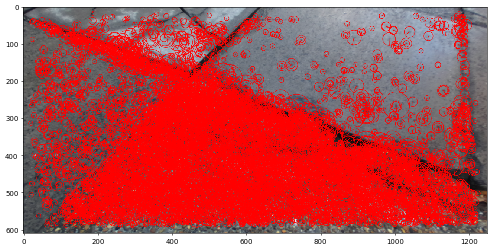

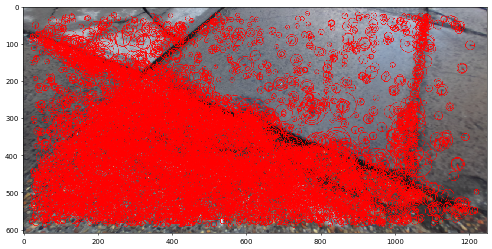

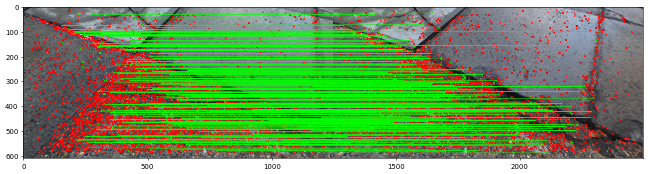

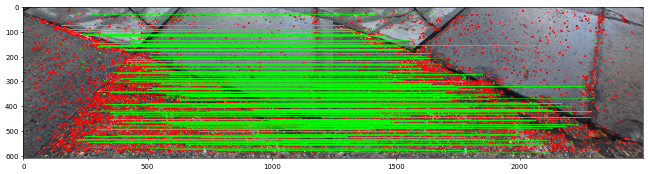

In [91]:
import numpy as np
from sklearn.preprocessing import normalize
import cv2
from matplotlib import pyplot as plt
import glob
from scipy.optimize import leastsq
from numba import jit

def filter_matches_outliers(match, epsilon):
    """
    Filter matched features from two images by ******
    通过间距过滤匹配
    Arguments:
    match -- list of matched features from two images
    epsilon -- defined by Rui,F Paper, a st atic value to 1
    
    Returns:
    filtered_match -- list of good matches, satisfying the Rui,F
    """ 
    filtered_match = []
    NG = []
    for i in range(len(match)):
    # Get the matching keypoints for each of the images
        img1_idx = match[i][0].queryIdx
        img2_idx = match[i][0].trainIdx
        # Get the coordinates
        (ul, vl) = kp1[img1_idx].pt
        (ur, vr) = kp2[img2_idx].pt
        if abs(vl - vr) > epsilon or (ul - ur)< 0:
            NG.append(match[i])
    filtered_match = [item for item in match if item not in NG]

    return filtered_match

def extract_features(image):
    """
    Find keypoints and descriptors for the image
    使用'BRISK'返回图片的关键点与描述符
    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    # Initiate BRISK detector
    detector = cv2.BRISK_create(20,3)
#     detector = cv2.BRISK_create()

    # find the keypoints and descriptors with SIFT
    kp, des = detector.detectAndCompute(image,None)
    im_with_keypoints = cv2.drawKeypoints(image, kp,
                                          np.array([]),
                                          (255,0,0),
                                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(16, 6), dpi=50)
    plt.imshow(im_with_keypoints)  

    return kp, des

def visualize_features(image, kp):
    """
    Visualize extracted features in the image
    显示图片的特征值
    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
#     display = cv2.drawKeypoints(image, kp, None)
    im_with_keypoints = cv2.drawKeypoints(image, kp,
                                          np.array([]),
                                          (255,0,0),
                                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 6), dpi=50)
    plt.imshow(im_with_keypoints)

def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset
    返回图片集的关键点与描述符
    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
           
    for img in images:
        kp, des = extract_features_function(img)
        kp_list.append(kp)
        des_list.append(des)
    return kp_list, des_list

def match_features(des1, des2):
    """
    Match features from two images
    返回匹配
    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    bf = cv2.BFMatcher(cv2.NORM_L2SQR)
    match = bf.knnMatch(des1,des2, k=2) # k=2 return only 2 matches
    return match

def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches
    通过间距过滤匹配
    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """

    filtered_match = []

    for m,n in match:
        if m.distance < dist_threshold * n.distance:
            filtered_match.append([m])
    return filtered_match

def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """ 
    
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = None,
                   flags = 0)
    image_matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, match,None,**draw_params)
    plt.figure(figsize=(16, 6), dpi=50)
    plt.imshow(image_matches)

# images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob("C:\\Users\\hp\\Script\\*.png")]
# images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob("/media/jayhsu0627/B/Script/*.png")]
# images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob("H:\\Script\\*.png")]

images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob("D:\Anaconda\Scripts\Road_Scripts\*.png")]
kp_list, des_list = extract_features_dataset(images, extract_features)
print(len(kp_list),len(des_list))

i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

n = None
filtering = 1

i = 0 
image1 = cv2.cvtColor(cv2.imread('11_L.png'), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread('11_R.png'), cv2.COLOR_BGR2RGB)

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.3
    match = filter_matches_distance(match, dist_threshold)
print("Number of features matched in L and R after filtering by distance: {2}".format(i, i+1, len(match)))
image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])  
match = filter_matches_outliers(match, 0.5)    
print("Number of features matched in L and R after filtering by Rui: {2}".format(i, i+1, len(match)))
filtered_match = match
# for m in filtered_match:
# # Get the matching keypoints for each of the images
#     img1_idx = m[0].queryIdx
#     img2_idx = m[0].trainIdx
#     # Get the coordinates
#     (ul, vl) = kp1[img1_idx].pt
#     (ur, vr) = kp2[img2_idx].pt
# #     print(ul,vl,ur,vr)
#     print(abs(vl - vr),(ul - ur))

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])  


a1,a0: [ 0.16850709 99.61006242]


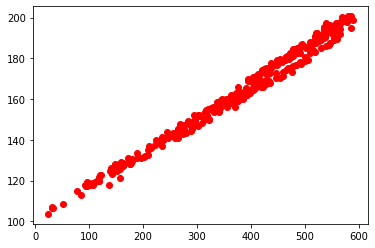

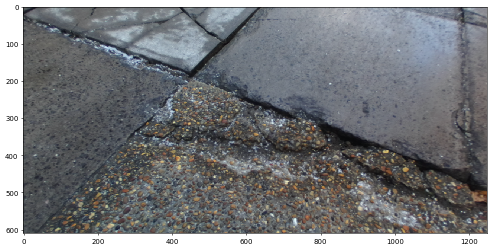

(610, 1249, 3)
rightwards: 182


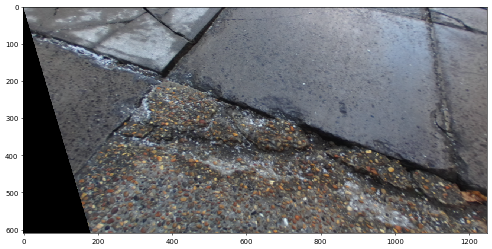

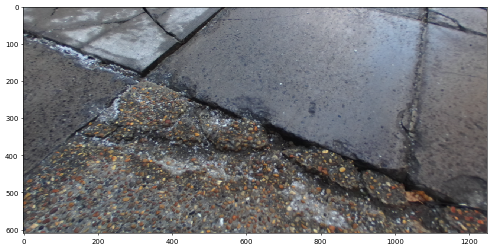

(610, 1249, 3)
leftwards: 182


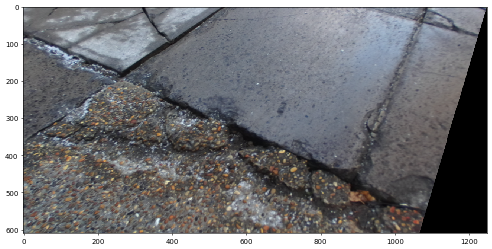

In [92]:
def Perspective_Transform(reliable_matches):

    n = len(reliable_matches)
    v = np.zeros(n)
    d = np.zeros(n)
    for i in range(len(reliable_matches)):
    # Get the matching keypoints for each of the images
        img1_idx = reliable_matches[i][0].queryIdx
        img2_idx = reliable_matches[i][0].trainIdx
        # Get the coordinates
        (ul, vl) = kp1[img1_idx].pt
        (ur, vr) = kp2[img2_idx].pt
        d[i] = ul - ur
        v[i] = (vl + vr)/2
#     print(d,v)

    H = np.ones((n,2))
    H[:, 0] = v
    x_ls = np.linalg.inv(H.T.dot(H)).dot(H.T.dot(d))
    print("a1,a0:",x_ls)
    a1, a0 = x_ls
    plt.plot(v, d, 'ro')  
    return a1, a0
def left_PT(image,a0,a1,delta = 20):
    rows,cols,ch = image.shape
    print(image.shape)
    tx = int(a0 + a1 * rows - delta)
    print("rightwards:",tx)
    pts1 = np.float32([[0,0],
                       [cols,0],
                       [0,rows],
                       [cols,rows]])
    pts2 = np.float32([[0,0],
                       [cols,0],
                       [tx,rows],
                       [cols + tx,rows]])
    M = cv2.getPerspectiveTransform(pts1,pts2)

#     dst = cv2.warpPerspective(image,M,(cols+tx,rows)) #Full picture
    dst = cv2.warpPerspective(image,M,(cols,rows)) #Same picture

    plt.figure(figsize=(16, 6), dpi=50)
    plt.imshow(dst)
    plt.show()
    return dst
def right_PT(image,a0,a1,delta = 20):
    rows,cols,ch = image.shape
    print(image.shape)
    tx = int(a0 + a1 * rows - delta)
    print("leftwards:",tx)
    pts1 = np.float32([[0,0],
                       [cols,0],
                       [0,rows],
                       [cols,rows]])
    pts2 = np.float32([[0,0],
                       [cols,0],
                       [-tx,rows],
                       [cols - tx,rows]])
    M = cv2.getPerspectiveTransform(pts1,pts2)

#     dst = cv2.warpPerspective(image,M,(cols+tx,rows)) #Full picture
    dst = cv2.warpPerspective(image,M,(cols,rows)) #Same picture
    plt.figure(figsize=(16, 6), dpi=50)
    plt.imshow(dst)
    plt.show()
    return dst

a1, a0 = Perspective_Transform(filtered_match)

# Transform from right to left
plt.figure(figsize=(16, 6), dpi=50)
plt.imshow(image1)                       # Reference Image denoted as IRef
plt.show()
Right = left_PT(image2,a0,a1,delta = 20) # Target    Image denoted as ITar


# Transform from left to right
plt.figure(figsize=(16, 6), dpi=50)
plt.imshow(image2)
plt.show()
Left = right_PT(image2,a0,a1,delta = 20)




(609, 1240) (609, 1240)
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
30144.724130630493 ms


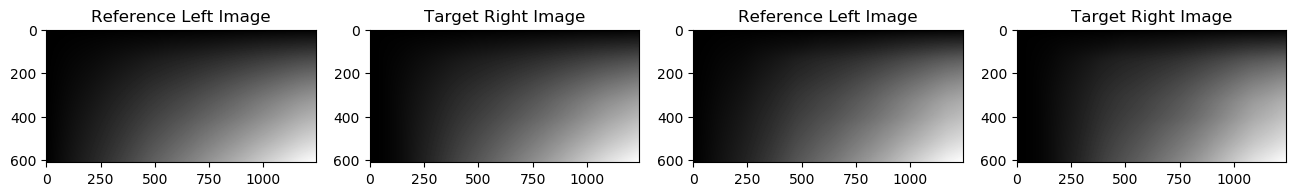

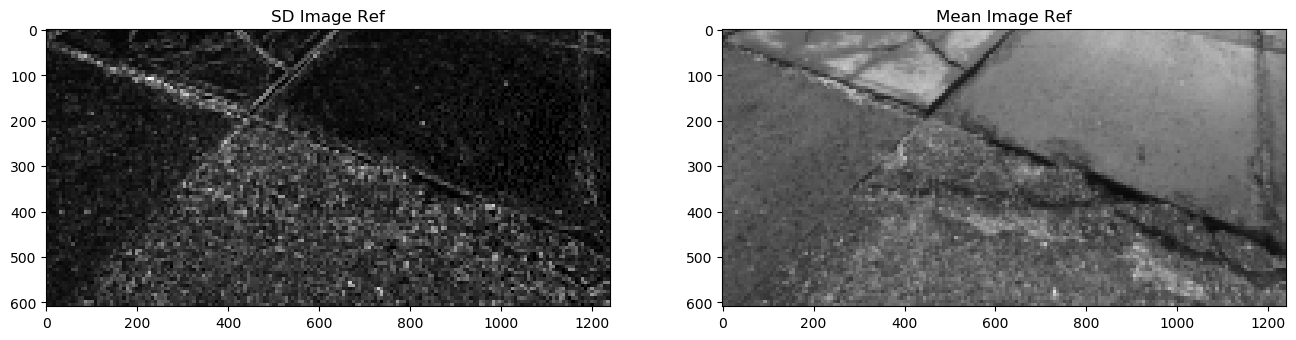

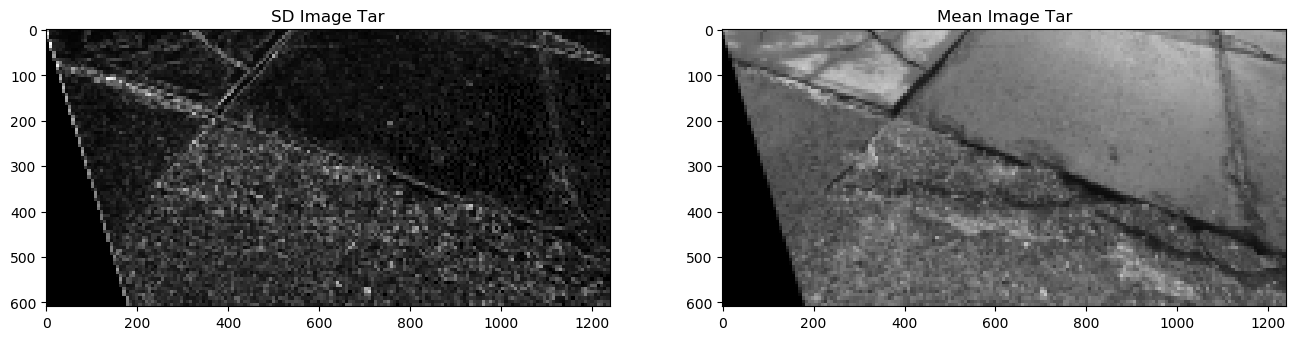

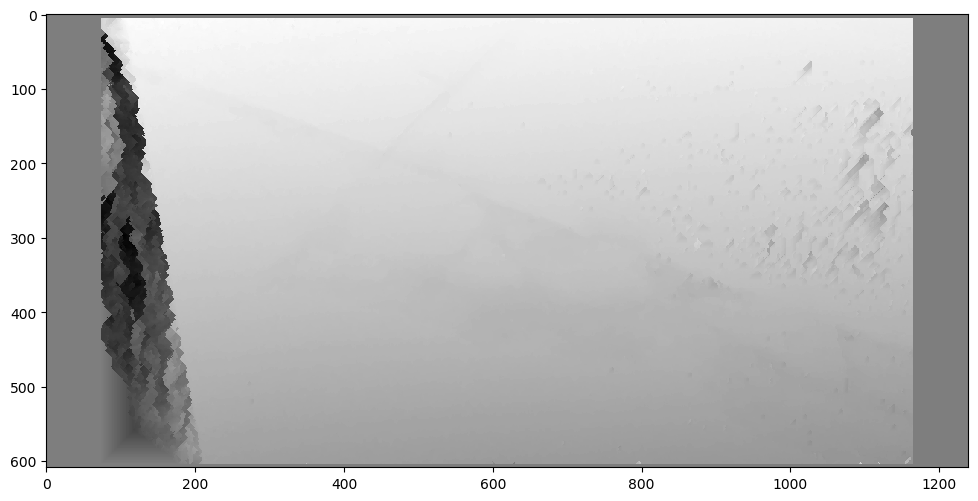

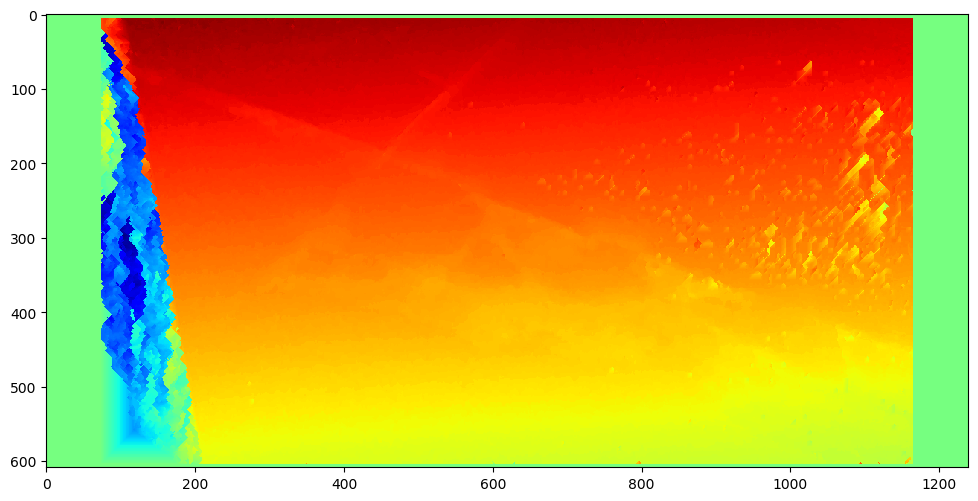

In [98]:
# https://cloud.tencent.com/developer/article/1357066
# https://techtutorialsx.com/2018/06/02/python-opencv-converting-an-image-to-gray-scale/
# https://blog.csdn.net/weixin_33755557/article/details/89938176

# Step 1 Integral_Image_Initialization
# from numba import jit

import math,time

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def integral_image(src):
    """
    Transform the RGB image into integral_image
    转换为积分图
    Arguments:
    src       -- input RGB image
    Returns:
    sum_table -- integral image
    """ 
    # If not gray convert gray, else pass
    if len(src.shape) > 2:
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        sum_table = cv2.integral(gray, sdepth = cv2.CV_32FC1)
    else:
        sum_table = cv2.integral(src, sdepth = cv2.CV_32FC1)
#     h, w = src.shape[:2] 
#     result = np.zeros((h + 1, w + 1), dtype = np.uint8)# The picture need to be convert into uint8 format, which means all value is cropped into 0-255
#     reult = sum_table
#     cv2.normalize(sum_table, result, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    return sum_table
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def int_img_value(sum_table,u,v):
    """
    get the intensity of sum_table @ [u,v]
    获取u，v处密度图
    Arguments:
    src       -- input RGB image
    Returns:
    sum_table -- integral image
    """ 
    sum_table_value = sum_table[u][v]
    return sum_table_value

# Step 2 Area sum of RoI
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def Block_Sum(sum_table, u, v, rho):
    """
    Get the sum of specific area, with 
    获取指定区域面积
    Arguments:
    src       -- input RGB image
    u, v      -- center coordinate of the region
    rho       -- edge width of the region
    Returns:
    sum_table -- integral image
    """ 
    while len(sum_table.shape) > 2:
        print('Please check input image shape!')
        return None
    else:
        r1 = int_img_value(sum_table,u + rho    ,v + rho    )
        r2 = int_img_value(sum_table,u - rho - 1,v - rho - 1)
        r3 = int_img_value(sum_table,u - rho - 1,v + rho    )
        r4 = int_img_value(sum_table,u + rho    ,v - rho - 1)
#         print(r1,r2,r3,r4)
        s = (r1 + r2 - r3 - r4)
#         s = np.float32((r1 + r2 - r3 - r4))
    # The value is first convert into int, which means it can be added freely, then the result was converted into uint8
    # otherwise the IDE would pop up Error, since the value during operation may out of bound of uint8
    return s

# Step 3 Generate Standard Deviation Map / Mean Map

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def mean_map(img,sumtable,sumtable2,rho):
    """
    Generate a MxN Standard Deviation Map / Mean Map for a given MxN image
    为给定图片生成相同大小MxN的标准差和均值图
    Arguments:
    img             -- input Gray image
    rho             -- edge width of the region
    Returns:
    SD_map,mean_map -- Standard Deviation Map / Mean Map
    """ 
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = 2 * rho + 1
    print("Window size:",edge,"x",edge)
    wx = wy = edge    
    h,w  = img.shape[:2]
    # The true cases have four scenerio,
    #      w   h   Covered
    #   1  G   G   N
    #   2  G   B   Y
    #   3  B   G   Y
    #   4  B   B   N
    # depoly more cases to provide better performance
    if h % wx != 0:
        print("Image Cropped under correct window size. The final row would be pasted from last row.")
        img = img[:h - h % wx,:]
        h = h - h % wx
        print(h%wx,w%wy)
        means_result = Calculate_Mean(img,sumtable,h,w,rho).astype(float)
        means_result = np.hstack((means_result, np.tile(means_result[[-h % wx],:], 1)))
        
    if w % wy != 0:
        print("Image Cropped under correct window size. The final col would be coppied from last col.")
        img = img[:,:w - w % wy]
        w = w - w % wy
        means_result = Calculate_Mean(img,sumtable,h,w,rho).astype(float)
        means_result = np.hstack((means_result, np.tile(means_result[:, [-w % wy]], 1)))
        
    return means_result

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def Calculate_Mean(img,sumtable,h,w,rho):
    means_result = np.zeros_like(img,dtype = np.float32)
    edge         = 2 * rho + 1
    for i in range (rho+1,h , edge):
        for j in range (rho+1,w, edge):
            mean = Block_Sum(sumtable, i, j, rho)/(edge**2)
            means_result[i - rho - 1:i + rho,j - rho - 1:j + rho] = np.full((edge, edge), mean)
    return means_result

def sd_map(img,sumtable,sumtable2,rho,m):
    """
    Generate a MxN Standard Deviation Map / Mean Map for a given MxN image
    为给定图片生成相同大小MxN的标准差和均值图
    Arguments:
    img             -- input Gray image
    rho             -- edge width of the region
    Returns:
    SD_map,mean_map -- Standard Deviation Map / Mean Map
    """ 
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = 2 * rho + 1
    print("Window size:",edge,"x",edge)
    wx = wy = edge    
    h,w  = img.shape[:2]
    # The true cases have four scenerio,
    #      w   h   Covered
    #   1  G   G   N
    #   2  G   B   Y
    #   3  B   G   Y
    #   4  B   B   N
    # depoly more cases to provide better performance
    if h % wx != 0:
        print("Image Cropped under correct window size. The final row would be pasted from last row.")
        img = img[:h - h % wx,:]
        h = h - h % wx
        print(h%wx,w%wy)
                
        SD_result    = Calculate_Std(img,sumtable,sumtable2,h,w,rho,m).astype(float)
        SD_result    = np.hstack((SD_result   , np.tile(SD_result[[-h % wx],:], 1)))
    if w % wy != 0:
        print("Image Cropped under correct window size. The final col would be coppied from last col.")
        img = img[:,:w - w % wy]
        w = w - w % wy
        SD_result    = Calculate_Std(img,sumtable,sumtable2,h,w,rho,m).astype(float)
        SD_result    = np.hstack((SD_result   , np.tile(SD_result[:, [-w % wy]], 1)))
    return SD_result

def Calculate_Std(img,sumtable,sumtable2,h,w,rho,m):
    SD_result    = np.zeros_like(img,dtype = np.float32)
    edge         = 2 * rho + 1
    for i in range (rho+1,h, edge):
        for j in range (rho+1,w, edge):
#             print(Block_Sum(sumtable2, i, j, rho)/(edge**2) ,m[i,j]**2)
            if Block_Sum(sumtable2, i, j, rho)/(edge**2) >= m[i,j]**2:
                sd   = np.sqrt(Block_Sum(sumtable2, i, j, rho)/(edge**2) 
                               - m[i,j]**2# the mean should be mean of the window but not the current loop center
                              )
#             if sumtable2[i,j]/(edge**2) >= m[i,j]**2:          
#                 sd   = np.sqrt(sumtable2[i, j]/(edge**2) 
#                    - m[i,j]**2# the mean should be mean of the window but not the current loop center
#                   )
            else:
                sd   = 0
            SD_result[i - rho - 1:i + rho,j - rho - 1:j + rho]= np.full((edge, edge), sd)
    return SD_result

# Step 4 Normalize Cross Correlation (NCC)
 
# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def getNCC(iL,iR,ul,ur,v,rho,m_l,m_r,sd_lr,int_l,int_r):
    """
    Get NCC from left to right 
    获取图片间相关系数
    Arguments:
    iL             -- a numpy array of left image in defined window, within given ul,ur
    iR             -- a numpy array of right image in defined window, within given ul,ur
    ul             -- x position of left image
    ur             -- x position of right image
    v              -- y position of both images
    rho            -- edge width of the region
    Returns:
    Corr      -- Normalize Cross Correlation
    """
    WindowEdge = 2 * rho + 1
    Pts_n = WindowEdge**2
    crossCumSum = 0
    product_1 = int_l[v - rho - 1:v + rho,
                   ul - rho - 1: ul + rho].astype(float)
    
    product_2 = int_r[v - rho - 1:v + rho,
                   ur - rho - 1: ur + rho].astype(float)
    crossCumSum = np.vdot(product_1,product_2)
#     print("CrossSum:",crossCumSum, m_l[v,ul], m_r[v,ur])
#     print(crossCumSum -  Pts_n*m_l[v,ul] * m_r[v,ur],Pts_n * sd_lr)
    corr = ( crossCumSum -  Pts_n*m_l[v,ul] * m_r[v,ur])/(Pts_n * sd_lr)
    return corr

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def getNCC_old(rightImage,leftImage,ul,ur,v,rho,d):
    windowSize = rho
    nElements = ( 2 * rho + 1)**2
    meanL,meanR,crossCumSum,cummSumR,cummSumL = 0.0,0.0,0.0,0.0,0.0
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ul - windowSize - 1,ul + windowSize):
            meanL += leftImage[m][n] / nElements
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ur - windowSize - 1,ur + windowSize):
            meanR += rightImage[m][n] / nElements 
#     print(meanL,meanR)
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ul - windowSize - 1,ul + windowSize):
            cummSumL += (leftImage[m][n] -  meanL)**2
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ur - windowSize - 1,ur + windowSize):
            cummSumR += (rightImage[m][n] - meanR)**2
            
    for m in range(v-windowSize-1,v+windowSize):
        for n in range(ul-windowSize-1,ul+windowSize):
            crossCumSum += (rightImage[m][n-d] - meanR)*(leftImage[m][n] -  meanL)
    if cummSumR * cummSumL > 0:
        cross = crossCumSum / math.sqrt(cummSumR * cummSumL)
    else:
        cross = 0
    return cross

# Step 5 Main____Left disparity map estimation

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def Left_Disparity_Map(left_img,right_img,left_integral,right_integral,left_mean,right_mean,left_sig,right_sig,dmin,dmax,rho):
    """
    Left disparity map estimation
    左视图视差图估计
    Arguments:
    left_img               -- Gray map of left image ?
    right_img              -- Gray map of of right image ?
    left_mean              -- left mean
    right_mean             -- right mean
    left_sig               -- left standard deviation
    right_sig              -- right standard deviation
    dmin                   -- Minimum search depth 
    dmax                   -- Maximum search depth 
    rho                    -- edge width of the region
          
    Returns:
    Corr      -- Normalize Cross Correlation
    """
    
    M,N          = left_img.shape
    Disparity_lf = np.zeros_like(left_img).astype(float)
    SR = []
    #If valid M x N Shape of all six input maps
    
    # Search START_LINE
    # The endline searching
    v = M - rho - 2
    for ul in range(rho + dmax + 1, N - rho - dmax - 2,1):
        corr  = np.zeros(dmax - dmin)
        for di in range(dmin,dmax):
            ur    = ul - di
#             print("di",di,"ul",ul,"ur",ur,left_sig[v,ul] , right_sig[v,ur])

            if(left_sig[v,ul] * right_sig[v,ur] != 0): # Not black
                sd_lr = left_sig[v,ul] * right_sig[v,ur]
#                 getNCC(left_img,right_img,ul,ur,v,rho,left_mean,right_mean,left_sig,right_sig,sd_lr)
#                 print(getNCC(left_img,right_img,ul,ur,v,rho,left_mean,right_mean,left_sig,right_sig,sd_lr),
#                   getNCC_old(right_img,left_img,ul,ur,v,3,di))
#                 corr_     = getNCC(left_img,right_img,ul,ur,v,rho,left_mean,right_mean,sd_lr,left_integral,right_integral)
                corr[di]  = getNCC_old(right_img,left_img,ul,ur,v,3,di)
#                 print("NCC vs Old:",corr_,corr[di])
#         print("Corr",corr)
        Disparity_lf[v,ul]= corr.argmax()
#     for i in range(1240):
#         print(Disparity_lf[604,i])
#     The rest lines searching
#     print("Here_1")
    for v in range(M - rho - 3, rho + 1,-1):
        for ul in range(rho + dmax + 1, N - rho - dmax - 2,1):
            SR = np.concatenate(( [Disparity_lf[ v + 1, ul - 1 ] - 1]
                                 ,[Disparity_lf[ v + 1, ul - 1 ] ]   
                                 ,[Disparity_lf[ v + 1, ul - 1 ] + 1]
                                 ,[Disparity_lf[ v + 1, ul     ] - 1]
                                 ,[Disparity_lf[ v + 1, ul     ]  ]  
                                 ,[Disparity_lf[ v + 1, ul     ] + 1]
                                 ,[Disparity_lf[ v + 1, ul + 1 ] - 1]
                                 ,[Disparity_lf[ v + 1, ul + 1  ]   ]
                                 ,[Disparity_lf[ v + 1, ul + 1 ] + 1]
                                )).astype(int)
#             print(SR)
            corr = np.zeros(len(SR))
#             print("SR",SR)
            for i in range(len(SR)):
#                 print(di)
#                 print(corr)
                di = SR[i]
                ur = ul - di
#                 print(ul,ur,v)
                if(left_sig[v , ul] * right_sig[v , ur] != 0):
                    sd_lr     = left_sig[v , ul] * right_sig[v , ur]
#                     corr[di]  = getNCC(left_img,right_img,ul,ur,v,rho,left_mean,right_mean,left_sig,right_sig,sd_lr)
#                     if(getNCC_old(right_img,left_img,ul,ur,v,3,di) == True):
                    corr[i]  = getNCC_old(right_img,left_img,ul,ur,v,3,di)
#                     corr[i]  = getNCC(left_img,right_img,ul,ur,v,rho,left_mean,right_mean,left_sig,right_sig,sd_lr)

#             print(corr)
            Disparity_lf[v , ul]= SR[corr.argmax()]

#     print(Disparity_lf)
    return Disparity_lf


# Left as Ref:IRef to Right as Tar:ITar
global IRef,ITar,I2Ref,I2Tar
IRef = integral_image(image1)
ITar = integral_image(Right)
# I2Ref = integral_image(np.square(image1))
# I2Tar = integral_image(np.square(Right))
NA,I2Ref =cv2.integral2(cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY), sdepth = cv2.CV_64F)
NB,I2Tar =cv2.integral2(cv2.cvtColor(Right, cv2.COLOR_BGR2GRAY), sdepth = cv2.CV_64F)
# print(I2Ref,I22Ref)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,4,1)
plt.title('Reference Left Image')
ax1.imshow(IRef, cmap='gray')
ax2 = fig.add_subplot(1,4,2)
plt.title('Target Right Image')
ax2.imshow(ITar, cmap='gray')
ax3 = fig.add_subplot(1,4,3)
plt.title('Reference Left Image')
ax3.imshow(I2Ref, cmap='gray')
ax4 = fig.add_subplot(1,4,4)
plt.title('Target Right Image')
ax4.imshow(I2Tar, cmap='gray')


image1 = image1[:609,:1240]
Right = Right[:609,:1240]
IRef = IRef[:609,:1240]
I2Ref = I2Ref[:609,:1240]
ITar = ITar[:609,:1240]
I2Tar = I2Tar[:609,:1240]

global sd_l,sd_r,m_l,m_r
print(IRef.shape,I2Ref.shape)
m_l  = mean_map(image1,IRef,I2Ref,3)
m_r  = mean_map(Right,ITar,I2Tar,3)
sd_l = sd_map(image1,IRef,I2Ref,3,m_l)
sd_r = sd_map(Right,ITar,I2Tar,3,m_r)
# print(sd_l,sd_r,m_l,m_r)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,2,1)
plt.title('SD Image Ref')
ax1.imshow(sd_l, cmap='gray')
ax2 = fig.add_subplot(1,2,2)
plt.title('Mean Image Ref')
ax2.imshow(m_l, cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,2,1)
plt.title('SD Image Tar')
ax1.imshow(sd_r, cmap='gray')
ax2 = fig.add_subplot(1,2,2)
plt.title('Mean Image Tar')
ax2.imshow(m_r, cmap='gray', vmin=0, vmax=255)

left_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
Right_gray = cv2.cvtColor(Right, cv2.COLOR_BGR2GRAY)

# fig = plt.figure(figsize=(16,6), dpi=100)
# ax1 = fig.add_subplot(1,2,1)
# plt.title('left Image')
# ax1.imshow(left_gray, cmap='gray', vmin=0, vmax=255)
# ax2 = fig.add_subplot(1,2,2)
# plt.title('Right Image')
# ax2.imshow(Right_gray, cmap='gray', vmin=0, vmax=255)

start = time.time()
Disparity_lf = Left_Disparity_Map(left_gray,Right_gray,IRef,ITar,m_l,m_r,sd_l,sd_r,0,70,3)
end = time.time()
print((end - start)*1000,"ms")

# cv2.normalize(Disparity_lf, Disparity_lf, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="gray", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="gray")
plt.show()
plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="cool", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="jet")
plt.show()


(609, 1240) (609, 1240)
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
Window size: 7 x 7
Image Cropped under correct window size. The final col would be coppied from last col.
51806.963205337524 ms


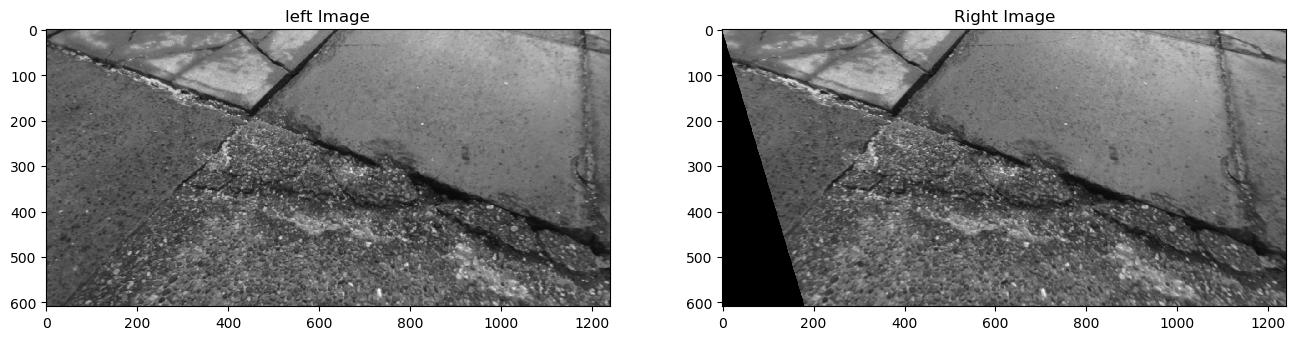

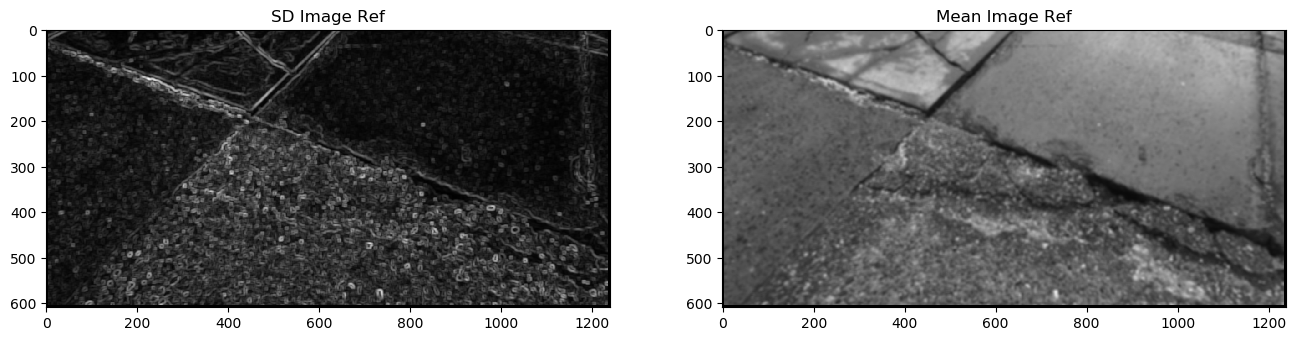

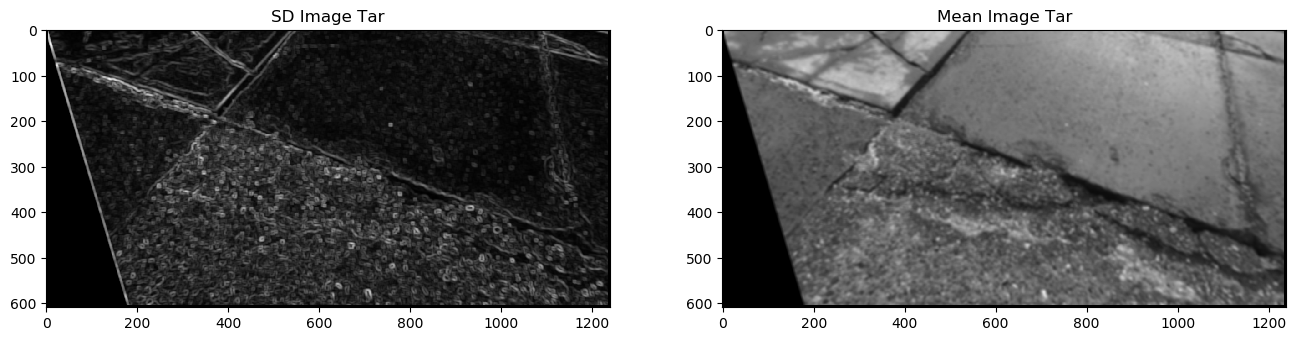

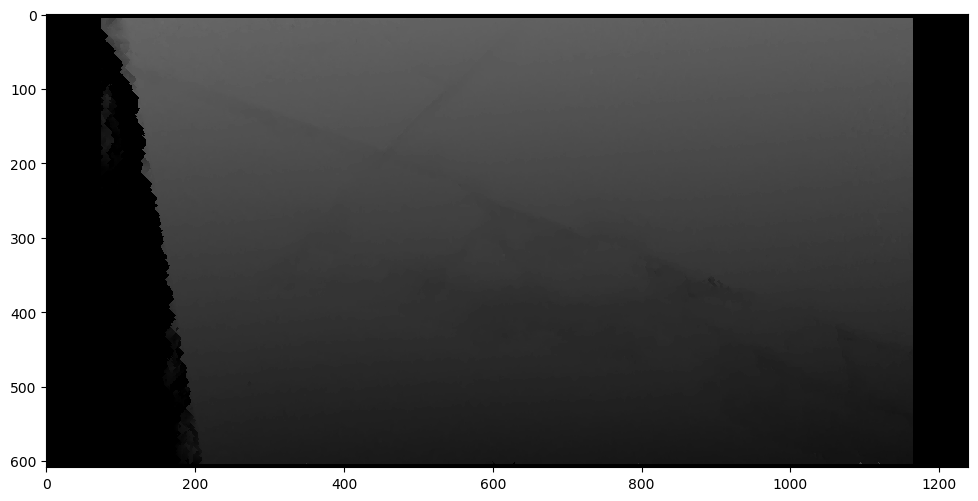

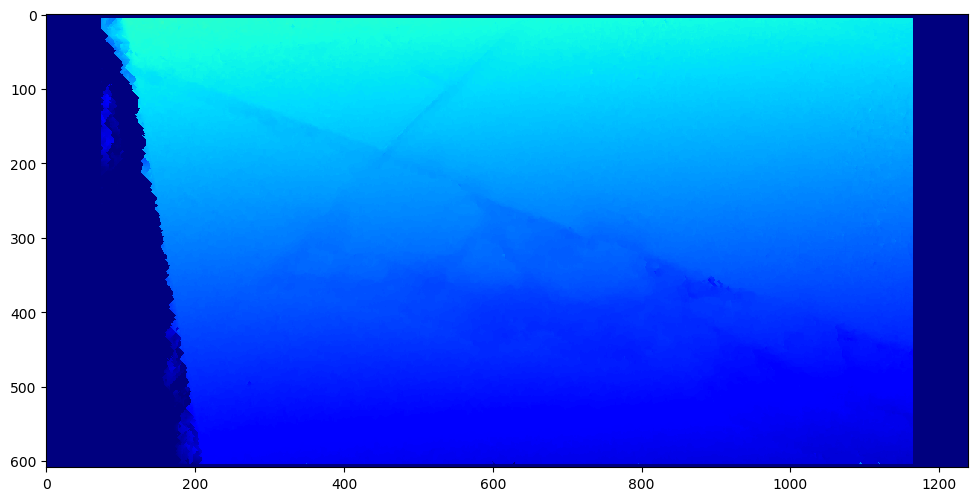

In [102]:
# https://cloud.tencent.com/developer/article/1357066
# https://techtutorialsx.com/2018/06/02/python-opencv-converting-an-image-to-gray-scale/
# https://blog.csdn.net/weixin_33755557/article/details/89938176

# Step 1 Integral_Image_Initialization
# from numba import jit
import math

# Step 2 Area sum of RoI

# Step 3 Generate Standard Deviation Map / Mean Map

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def mean_std_map(img,rho):
    """
    Generate a MxN Standard Deviation Map / Mean Map for a given MxN image
    为给定图片生成相同大小MxN的标准差和均值图
    Arguments:
    img             -- input Gray image
    rho             -- edge width of the region
    Returns:
    SD_map,mean_map -- Standard Deviation Map / Mean Map
    """ 
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = 2 * rho + 1
    print("Window size:",edge,"x",edge)
    wx = wy = edge    
    h,w  = img.shape[:2]
    # The true cases have four scenerio,
    #      w   h   Covered
    #   1  G   G   N
    #   2  G   B   Y
    #   3  B   G   Y
    #   4  B   B   N
    # depoly more cases to provide better performance   
   
    if h % wx != 0:
        print("Image Cropped under correct window size. The final row would be pasted from last row.")
        img = img[:h - h % wx,:]
        h = h - h % wx
        m_result = np.zeros_like(img,dtype = np.float32)
        std_result = np.zeros_like(img,dtype = np.float32)
        edge         = 2 * rho + 1
        for i in range (rho+1,h - rho - 1 , 1):
            for j in range (rho+1,w - rho - 1, 1):
                m, std = Mean_Std(img[i - rho - 1:i + rho,j - rho - 1:j + rho],mask=None)
                m_result[i,j] = m
                std_result[i,j] = std
#             means_result = np.hstack((means_result, np.tile(means_result[[-h % wx],:], 1)))
        
    if w % wy != 0:
        print("Image Cropped under correct window size. The final col would be coppied from last col.")
        img = img[:,:w - w % wy]
        w = w - w % wy
        m_result = np.zeros_like(img,dtype = np.float32)
        std_result = np.zeros_like(img,dtype = np.float32)
        edge         = 2 * rho + 1
        for i in range (rho+1,h - rho - 1 , 1):
            for j in range (rho+1,w - rho - 1, 1):
                m, std = Mean_Std(img[i - rho - 1:i + rho,j - rho - 1:j + rho],mask=None)
                m_result[i,j] = m
                std_result[i,j] = std
    return m_result,std_result


# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def Mean_Std(img,mask=None):
    m, std = cv2.meanStdDev(img, mask)
    return m,std

# Step 4 Normalize Cross Correlation (NCC)
 
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def getNCC(iL,iR,ul,ur,v,rho,m_l,m_r,sd_lr):
    """
    Get NCC from left to right 
    获取图片间相关系数
    Arguments:
    iL             -- a numpy array of left image in defined window, within given ul,ur
    iR             -- a numpy array of right image in defined window, within given ul,ur
    ul             -- x position of left image
    ur             -- x position of right image
    v              -- y position of both images
    rho            -- edge width of the region
    Returns:
    Corr      -- Normalize Cross Correlation
    """
    img_l = iL[v - rho - 1:v + rho,
                   ul - rho - 1: ul + rho].flatten().astype(np.float32)
    img_r = iR[v - rho - 1:v + rho,
                   ur - rho - 1: ur + rho].flatten().astype(np.float32)
    corr = ( np.vdot(img_l,img_r) - Pts_n * m_l * m_r)/(Pts_n * sd_lr)
    return corr

# Step 5 Main____Left disparity map estimation

# @jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def Left_Disparity_Map(left_img,right_img,left_mean,right_mean,left_sig,right_sig,dmin,dmax,rho):
    """
    Left disparity map estimation
    左视图视差图估计
    Arguments:
    left_img               -- Gray map of left image ?
    right_img              -- Gray map of of right image ?
    left_mean              -- left mean
    right_mean             -- right mean
    left_sig               -- left standard deviation
    right_sig              -- right standard deviation
    dmin                   -- Minimum search depth 
    dmax                   -- Maximum search depth 
    rho                    -- edge width of the region
          
    Returns:
    Corr      -- Normalize Cross Correlation
    """
    
    M,N          = left_img.shape
    Disparity_lf = np.zeros_like(left_img).astype(np.float32)
    SR = []

    #If valid M x N Shape of all six input maps
    
    # Search START_LINE
    # The endline searching
    v = M - rho - 2
    for ul in range(rho + dmax + 1, N - rho - dmax - 2,1):
        corr  = np.zeros(dmax - dmin)
        for di in range(dmin,dmax):
            ur    = ul - di
            if(left_sig[v,ul] * right_sig[v,ur] != 0): # Not black
                sd_lr = left_sig[v,ul] * right_sig[v,ur]
                corr[di]  = getNCC(left_img,right_img,ul,ur,v,rho,m_l[v,ul],m_r[v,ur],sd_lr)
                
        Disparity_lf[v,ul]= corr.argmax()
#     The rest lines searching
    for v in range(M - rho - 3, rho + 1,-1):
#         print("row:",v)
        for ul in range(rho + dmax + 1, N - rho - dmax - 2,1):
            arrs = [a for a in ([Disparity_lf[ v + 1, ul - 1 ] - 1],
                                [Disparity_lf[ v + 1, ul - 1 ]    ],
                                [Disparity_lf[ v + 1, ul - 1 ] + 1],
                                [Disparity_lf[ v + 1, ul     ] - 1],
                                [Disparity_lf[ v + 1, ul     ]    ],
                                [Disparity_lf[ v + 1, ul     ] + 1],
                                [Disparity_lf[ v + 1, ul + 1 ] - 1],
                                [Disparity_lf[ v + 1, ul + 1 ]    ],
                                [Disparity_lf[ v + 1, ul + 1 ] + 1]
                               ) if a is not None]
            SR = np.concatenate(arrs).astype(np.int16)

#             SR = np.concatenate(( [Disparity_lf[ v + 1, ul - 1 ] - 1]
#                                  ,[Disparity_lf[ v + 1, ul - 1 ] ]   
#                                  ,[Disparity_lf[ v + 1, ul - 1 ] + 1]
#                                  ,[Disparity_lf[ v + 1, ul     ] - 1]
#                                  ,[Disparity_lf[ v + 1, ul     ]  ]  
#                                  ,[Disparity_lf[ v + 1, ul     ] + 1]
#                                  ,[Disparity_lf[ v + 1, ul + 1 ] - 1]
#                                  ,[Disparity_lf[ v + 1, ul + 1  ]   ]
#                                  ,[Disparity_lf[ v + 1, ul + 1 ] + 1]
#                                 )).astype(np.int16)

            SR = np.unique(SR) # reduce search range, to remove duplicate number
#             print(SR)
            corr = np.zeros(len(SR))
            for j in range(len(SR)):
                di = SR[j]
                ur = ul - di
                if(left_sig[v , ul] * right_sig[v , ur] != 0):
                    sd_lr    = left_sig[v , ul] * right_sig[v , ur]
                    corr[j]  = getNCC(left_img,right_img,ul,ur,v,rho,m_l[v,ul],m_r[v,ur],sd_lr)
            Disparity_lf[v , ul]= SR[corr.argmax()]
    return Disparity_lf


# Left as Ref:IRef, Right as Tar:ITar
global IRef,ITar,sd_l,sd_r,m_l,m_r,WindowEdge,Pts_n
rho = 3
WindowEdge = 2 * rho + 1
Pts_n = WindowEdge**2

image1 = image1[:609,:1240]
Right = Right[:609,:1240]
IRef = IRef[:609,:1240]
ITar = ITar[:609,:1240]

print(IRef.shape,I2Ref.shape)
m_l,sd_l  = mean_std_map(image1,3)
m_r,sd_r  = mean_std_map(Right,3)

left_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
Right_gray = cv2.cvtColor(Right, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,2,1)
plt.title('left Image')
ax1.imshow(left_gray, cmap='gray', vmin=0, vmax=255)
ax2 = fig.add_subplot(1,2,2)
plt.title('Right Image')
ax2.imshow(Right_gray, cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,2,1)
plt.title('SD Image Ref')
ax1.imshow(sd_l, cmap='gray')
ax2 = fig.add_subplot(1,2,2)
plt.title('Mean Image Ref')
ax2.imshow(m_l, cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(16,6), dpi=100)
ax1 = fig.add_subplot(1,2,1)
plt.title('SD Image Tar')
ax1.imshow(sd_r, cmap='gray')
ax2 = fig.add_subplot(1,2,2)
plt.title('Mean Image Tar')
ax2.imshow(m_r, cmap='gray', vmin=0, vmax=255)

start = time.time()
Disparity_lf = Left_Disparity_Map(left_gray,Right_gray,m_l,m_r,sd_l,sd_r,0,70,3)
end = time.time()
print((end - start)*1000,"ms")

# cv2.normalize(Disparity_lf, Disparity_lf, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="gray", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="gray", vmin=0, vmax=255)
plt.show()
plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="cool", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="jet", vmin=0, vmax=255)
plt.show()

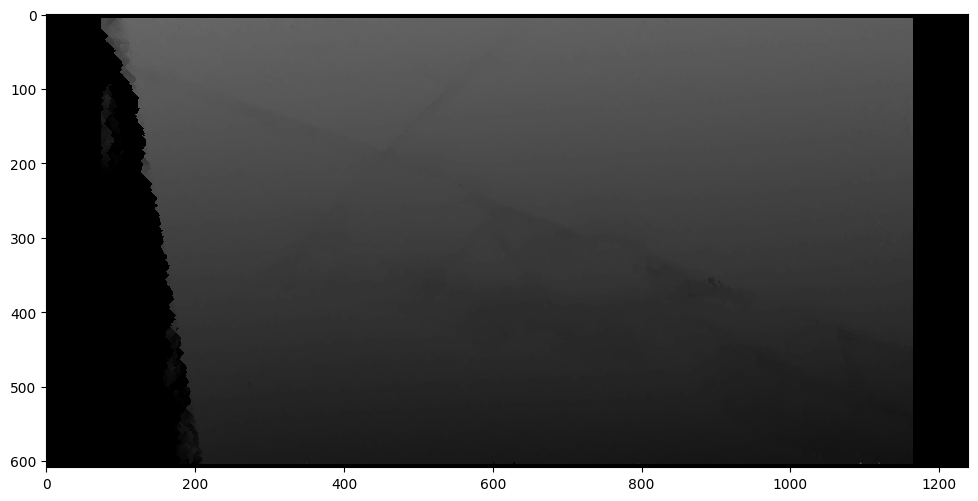

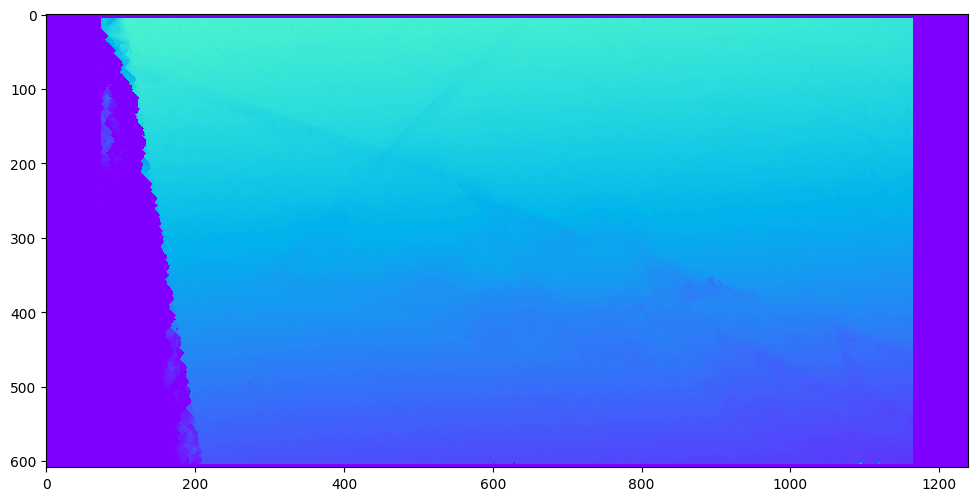

In [73]:
plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="gray", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="gray", vmin=0, vmax=255)
plt.show()
plt.figure(figsize=(16, 6), dpi=100)
# plt.imshow(Disparity_lf,cmap="cool", vmin=-300, vmax=300)
plt.imshow(Disparity_lf,cmap="rainbow", vmin=0, vmax=255)
plt.show()

In [33]:
import cv2,time
import numpy as np
img = np.array([[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, 1, 1, 0],
               [0, 1, 1, 1, 0],
               [0, 1, 1, 1, 0],
               [0, 0, 0, 0, 0]], dtype='uint8')
img = left_gray
# Calculate the standard deviation
# Here I'm taking the full image, you can take any rectangular region
# Method-1: using cv2.meanStdDev()
start = time.time()
mean, std_1 = cv2.meanStdDev(img, mask=None)
end = time.time()
print((end - start)*1000,"ms")

# Method-2: using the formulae 1/n(S2 - (S1**2)/n)
start = time.time()
sum_1, sqsum_2 = cv2.integral2(img)
n = img.size
# sum of the region can be easily found out using the integral image as
#  Sum = Bottom right + top left - top right - bottom left
s1 = sum_1[-1,-1]
s2 = sqsum_2[-1,-1]
std_2 = np.sqrt((s2 - (s1**2)/n)/n)
end = time.time()
print((end - start)*1000,"ms")
print(std_1, std_2)  # [[0.45825757]] 0.4582575694


0.3962516784667969 ms
5.817651748657227 ms
[[33.58948827]] 33.58948827225553


max at  42 0.9112777672716308


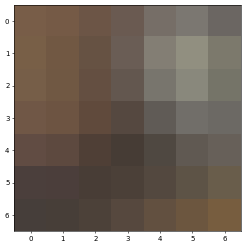

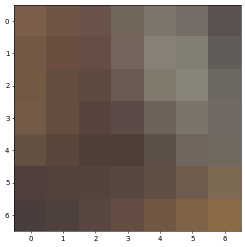

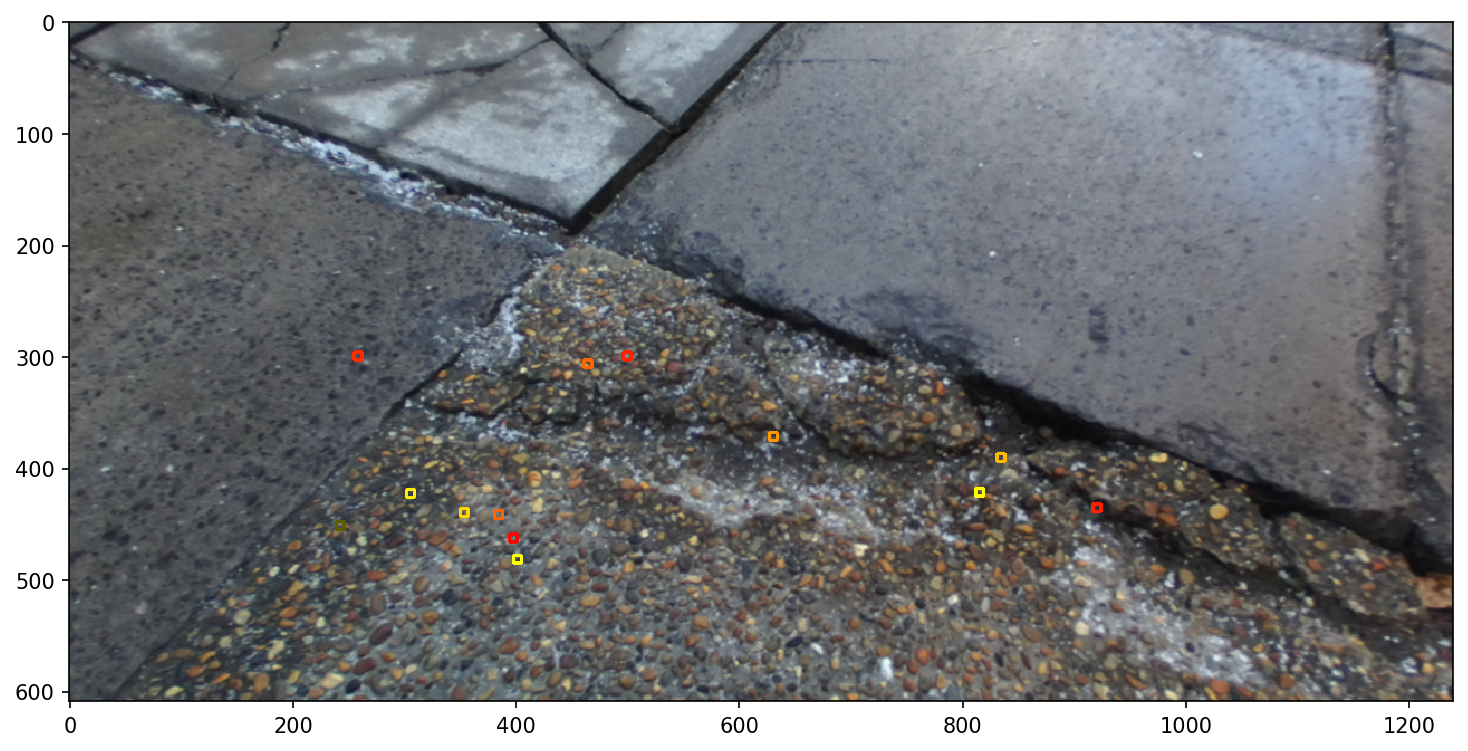

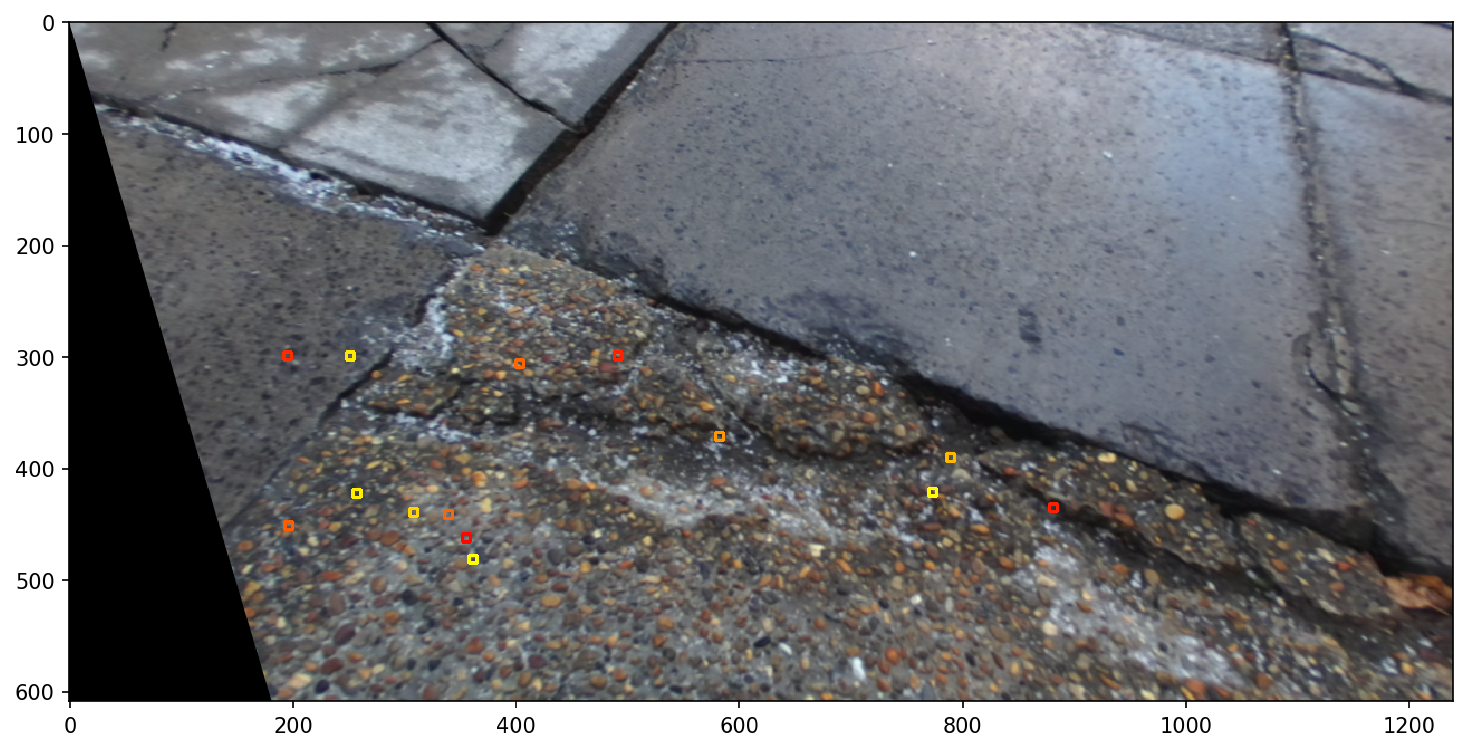

In [34]:
import random,time
rho =3
def getNCC_old(rightImage,leftImage,ul,ur,v,rho,d):
    windowSize = rho
    nElements = ( 2 * rho + 1)**2
    meanL,meanR,crossCumSum,cummSumR,cummSumL = 0.0,0.0,0.0,0.0,0.0
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ul - windowSize - 1,ul + windowSize):
            meanL += leftImage[m][n] / nElements
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ur - windowSize - 1,ur + windowSize):
            meanR += rightImage[m][n] / nElements 
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ul - windowSize - 1,ul + windowSize):
            cummSumL += (leftImage[m][n] -  meanL)**2
    for m in range(v - windowSize - 1,v + windowSize):
        for n in range(ur - windowSize - 1,ur + windowSize):
            cummSumR += (rightImage[m][n] - meanR)**2
            
    for m in range(v-windowSize-1,v+windowSize):
        for n in range(ul-windowSize-1,ul+windowSize):
            crossCumSum += (rightImage[m][n-d] - meanR)*(leftImage[m][n] -  meanL)
    if cummSumR * cummSumL > 0:
        cross = crossCumSum / math.sqrt(cummSumR * cummSumL)
    else:
        cross = 0
#     print("Old NCC")
#     print("m_L,m_r,:",meanL,meanR,nElements)
#     print("sd_L,sd_r,:",math.sqrt(cummSumL/nElements),math.sqrt(cummSumR/nElements))
#     print("Block_sum_l:",cummSumL+49*(meanL)**2,cummSumR+49*(meanR)**2)

    return cross

def getNCC(iL,iR,ul,ur,v,rho,sd_lr):
    WindowEdge = 2 * rho + 1
    Pts_n = WindowEdge**2
    crossCumSum = 0
    img_l = iL[v - rho - 1:v + rho,
                   ul - rho - 1: ul + rho]
    product_1 = img_l.flatten().astype(np.float32)
    img_r = iR[v - rho - 1:v + rho,
                   ur - rho - 1: ur + rho]
    product_2 = img_r.flatten().astype(np.float32)
    crossCumSum = np.dot(product_1,product_2)
    m_l, sd_l = cv2.meanStdDev(img_l, mask=None)
    m_r, sd_r = cv2.meanStdDev(img_r, mask=None)
    sd_lr = sd_l * sd_r
    
#     print("New NCC")
#     print("CrossSum,m_l,m_r:",crossCumSum, m_l, m_r)
#     print("sd_l,sd_r:",sd_l,sd_r)
    corr = ( crossCumSum - Pts_n * m_l * m_r)/(Pts_n * sd_lr)
    return corr

ul =random.randint(100,1000)
v =  random.randint(300,500)
depth = 110
temp = np.zeros(depth)
# def getNCC_old(rightImage,leftImage,ul,ur,v,rho):
for d in range(0,depth):
#     print("No.",d)
 x
    ur = ul - d   
    start_1 = time.time()
    temp_ = getNCC_old(Right_gray,left_gray,ul,ur,v,3,d)
    end_1 = time.time()

    sd_lr = sd_l[v,ul] * sd_r[v,ur]
    start_2 = time.time()
    temp[d] = getNCC(left_gray,Right_gray,ul,ur,v,3,sd_lr)
    end_2 = time.time()

#     print("New takes",(-start_2+end_2)*1000,"ms")
#     print("Old takes",(-start_1+end_1)*1000,"ms")

#     print(temp[d],temp_)
    
temp_max = temp.argmax()
print("max at ", temp_max,temp[temp_max])

plt.figure(figsize=(16, 6), dpi=50)
plt.imshow(image1[v - 3 -1:v + 3,
                  ul-3-1:ul+3])
plt.show()
plt.figure(figsize=(16, 6), dpi=50)
plt.imshow(Right[v - 3 -1:v + 3,
                 ul-temp_max-3-1:ul-temp_max+3])
plt.show()


aa = Right_gray[v - rho - 1:v + rho,
               ul - rho - 1: ul + rho]
# aa = aa.flatten()
bb = left_gray[v - rho - 1:v + rho,
               ur - rho - 1: ur + rho]

color = random.randint(0,255)

draw_0 = cv2.rectangle(image1, (ul-3-1,v - 3 -1), (ul+3,v + 3), (color,color,0),2)
plt.figure(figsize=(16, 6), dpi=150)
plt.imshow(draw_0)
plt.show()

draw_1 =  cv2.rectangle(Right, (ul-temp_max-3-1,v - 3 -1), (ul-temp_max+3,v + 3), (255,color,0),2)
plt.figure(figsize=(16, 6), dpi=150)
plt.imshow(draw_1)
plt.show()

